# Training a Machine Learning Classifier for HP-PPI Prediction Task

Classifier: XGBoost
- performs well with sparse variables
- needs no preprocessing

In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.calibration import CalibratedClassifierCV
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall
from hyperopt import hp, tpe, STATUS_OK, Trials, space_eval
from hyperopt.fmin import fmin

from IPython.display import display, Markdown

# Suppress warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.simplefilter('ignore', category=(UndefinedMetricWarning, RuntimeWarning))

In [2]:
# Set up directories
SEED = 714903286
parent_dir = os.path.dirname(os.getcwd())

dir_in = os.path.join(parent_dir, 'data', 'features')
dir_out = os.path.join(parent_dir, 'data', 'results')

In [3]:
# Function for combining datasets
def get_dataset(pathogens):
    '''Combine features and labels of different pathogen datasets'''
    
    X = []
    y = []
    
    # Iterate through datasets
    for pathogen in pathogens:
        f_in = os.path.join(dir_in, '%s_features.pkl' % pathogen)
        X_, y_ = joblib.load(f_in)
        X.append(X_)
        y.append(y_)
    
    # Combine features (X) and labels (y)
    X = sparse.vstack(X)
    y = np.concatenate(y)
    
    return X, y

In [20]:
# Load all datasets
pathogens = ['Bacan', 'Yerpe', 'Fratu']
X, y = get_dataset(pathogens)
print('Loaded %i samples with %i features' % X.shape)

# Split into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8,
                                                      stratify=y, random_state=SEED)

# Set up base classifier
clf = XGBClassifier(n_estimators=4000, random_state=SEED, n_jobs=6)

Loaded 306468 samples with 4456 features


## Hyperparameter Tuning

Bayesian optimization with `hyperopt`

In [11]:
# Custom evaluation metric for XGBoost
def f1_eval(y_pred, t):
    y_true = t.get_label()
    f1_error = 1 - f1_score(y_true, y_pred.round())
    
    return 'f1-error', f1_error

# Define objective function for hyperopt
def objective(params):
    _ = clf.set_params(**params)
    _ = clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                eval_metric=f1_eval, early_stopping_rounds=100,
                verbose=False)
    
    score = f1_score(y_valid, clf.predict(X_valid))
    return {'loss': -score, 'status': STATUS_OK}

In [12]:
# Define hyperparameter search space
param_space = {
    'max_depth': hp.choice('max_depth', range(1, 51)),
    'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
    'min_child_weight': hp.choice('min_child_weight', range(21)),
    'max_delta_step': hp.choice('max_delta_step', range(31)),
    'gamma': hp.uniform('gamma', 0, 10.0),
    
    'subsample': hp.uniform('subsample', 0.4, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.4, 1),
    
    'reg_alpha': hp.loguniform('reg_alpha', -5 * np.log(10), 0),
    'reg_lambda': hp.loguniform('reg_lambda', -5 * np.log(10), 0),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.1, 50)
}

# Begin optimization
trials = Trials()
best = fmin(objective, param_space, algo=tpe.suggest, max_evals=100, trials=trials)

# Obtain parameters of best model
best_params = space_eval(param_space, best)
best_params

100%|██████████| 100/100 [2:43:05<00:00, 160.25s/it, best loss: -0.80835734870317]


{'colsample_bylevel': 0.5976591786745346,
 'colsample_bytree': 0.9989436415392874,
 'gamma': 3.7852315106352314,
 'learning_rate': 0.22842061538159789,
 'max_delta_step': 17,
 'max_depth': 28,
 'min_child_weight': 4,
 'reg_alpha': 9.937144055789069e-05,
 'reg_lambda': 0.009088297316407444,
 'scale_pos_weight': 4.657988119313189,
 'subsample': 0.8299245594856989}

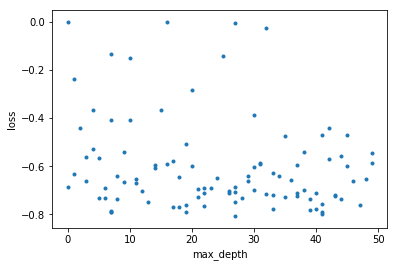

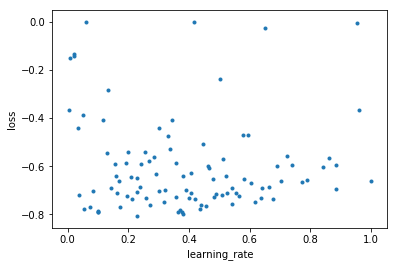

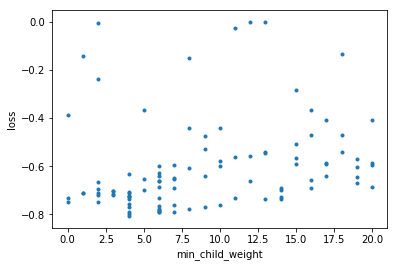

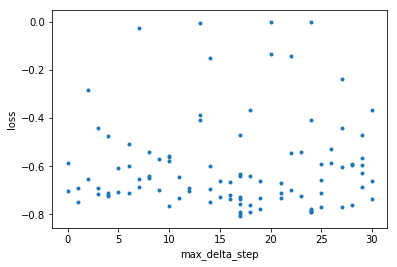

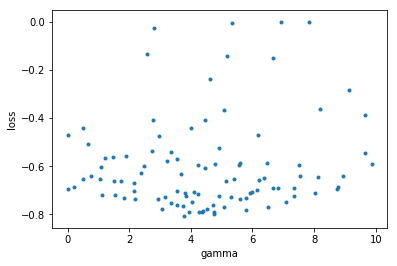

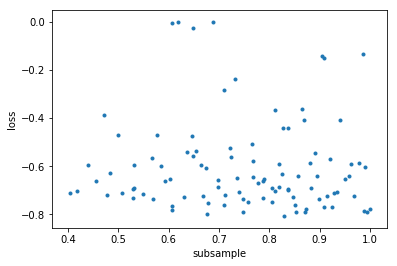

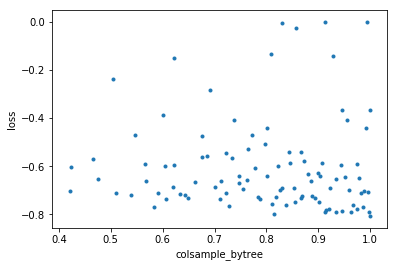

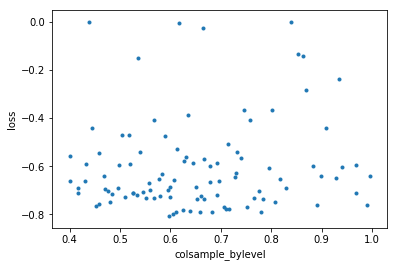

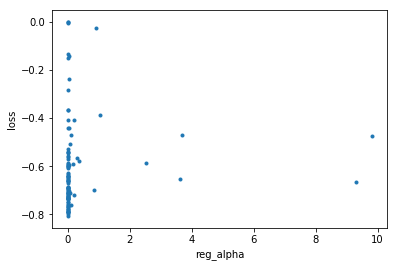

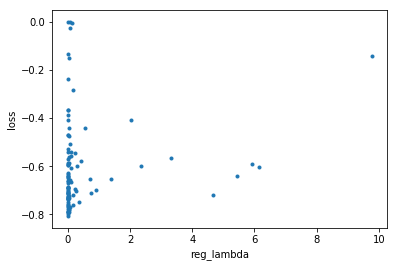

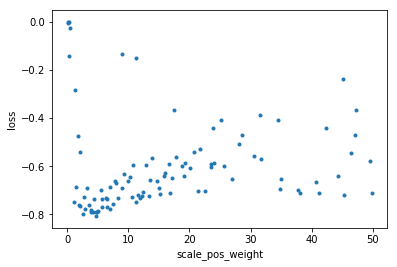

In [13]:
# Plot optimization progress: parameters vs loss
%matplotlib inline

for param in param_space.keys():
    xs = [t['misc']['vals'][param] for t in trials.trials]
    ys = [t['result']['loss'] for t in trials.trials]
    
    _ = plt.scatter(xs, ys, marker='.')
    _ = plt.xlabel(param)
    _ = plt.ylabel('loss')
    _ = plt.show()

## Probability calibration

In [14]:
# Train with validation
_ = clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
            eval_metric=f1_eval, early_stopping_rounds=100,
            verbose=1)

# Dump model as pickle
_ = joblib.dump(clf, 'best_model.pkl')

[0]	validation_0-error:0.023918	validation_0-f1-error:0.75645
Multiple eval metrics have been passed: 'validation_0-f1-error' will be used for early stopping.

Will train until validation_0-f1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.022286	validation_0-f1-error:0.753863
[2]	validation_0-error:0.022547	validation_0-f1-error:0.760176
[3]	validation_0-error:0.022465	validation_0-f1-error:0.785511
[4]	validation_0-error:0.022335	validation_0-f1-error:0.77301
[5]	validation_0-error:0.022808	validation_0-f1-error:0.8053
[6]	validation_0-error:0.022433	validation_0-f1-error:0.796178
[7]	validation_0-error:0.022139	validation_0-f1-error:0.785756
[8]	validation_0-error:0.022253	validation_0-f1-error:0.793023
[9]	validation_0-error:0.022351	validation_0-f1-error:0.794664
[10]	validation_0-error:0.021927	validation_0-f1-error:0.771527
[11]	validation_0-error:0.021992	validation_0-f1-error:0.778291
[12]	validation_0-error:0.021976	validation_0-f1-error:0.776369
[13]	validatio

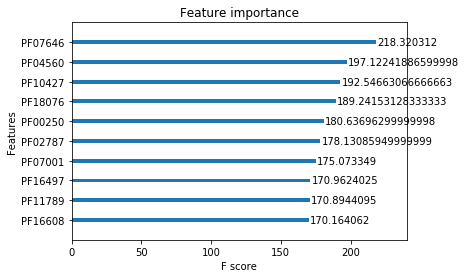

In [15]:
# Examine parameter importance
## Assign feature names
pfam = joblib.load('pfam.pkl')[1]

clf.get_booster().feature_names = pfam
_ = plot_importance(clf.get_booster(), importance_type='gain', max_num_features=10, grid=False)

## Evaluate model on partitioned datasets

In [28]:
clf

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.5976591786745346, colsample_bynode=1,
              colsample_bytree=0.9989436415392874, gamma=3.7852315106352314,
              learning_rate=0.22842061538159789, max_delta_step=17,
              max_depth=28, min_child_weight=4, missing=None, n_estimators=4000,
              n_jobs=6, nthread=None, objective='binary:logistic',
              random_state=714903286, reg_alpha=9.937144055789069e-05,
              reg_lambda=0.009088297316407444,
              scale_pos_weight=4.657988119313189, seed=None, silent=None,
              subsample=0.8299245594856989, verbosity=1)

                               Test 1                                
                          Test Pathogen: Bacan
                          
              precision    recall  f1-score   support

           0     0.9761    1.0000    0.9879    113032
           1     0.0000    0.0000    0.0000      2764

    accuracy                         0.9761    115796
   macro avg     0.4881    0.5000    0.4940    115796
weighted avg     0.9528    0.9761    0.9643    115796



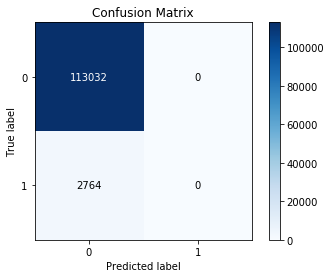

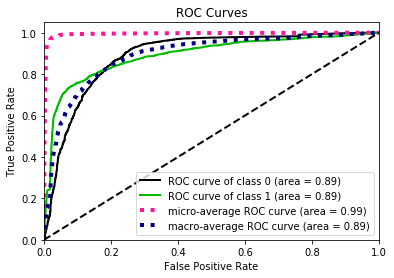

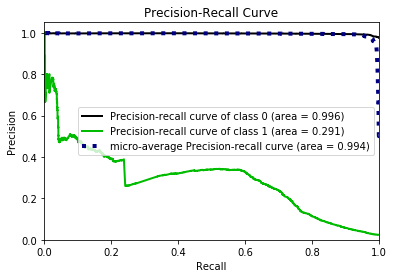

<hr></hr>

                               Test 2                                
                          Test Pathogen: Yerpe
                          
              precision    recall  f1-score   support

           0     0.9768    1.0000    0.9883    151383
           1     0.0000    0.0000    0.0000      3590

    accuracy                         0.9768    154973
   macro avg     0.4884    0.5000    0.4941    154973
weighted avg     0.9542    0.9768    0.9654    154973



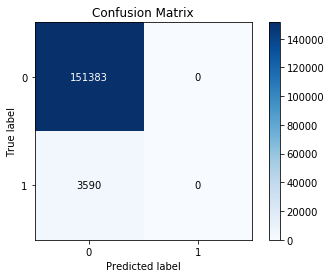

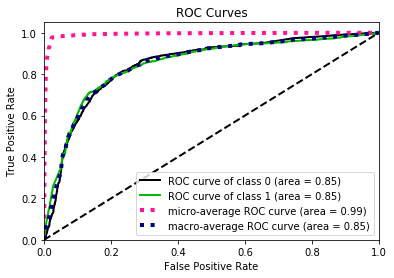

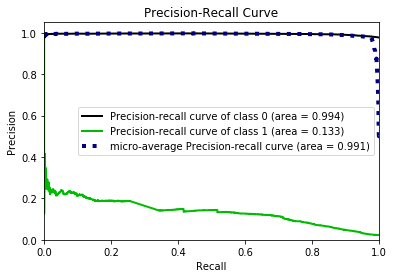

<hr></hr>

KeyboardInterrupt: 

In [30]:
# Train and test classifier on different datasets
## Partition datasets by pathogen species
%matplotlib inline
i = 0 # track number of tests

for p_test in pathogens:
    p_train = [p for p in pathogens if p != p_test]
    X_train, y_train = get_dataset(p_train)
    
    # Train classifier with validation set
    calibrated = CalibratedClassifierCV(clf, cv=5)
    _ = calibrated.fit(X_train, y_train)
    
    # Evaluate performance on test set
    X_test, y_test = get_dataset([p_test])
    y_pred = calibrated.predict(X_test)
    y_proba = calibrated.predict_proba(X_test)
    
    i += 1
    
    print('Test %i'.center(70) % i)
    print('Test Pathogen: %s\n'.center(70) % p_test)
    print(classification_report(y_test, y_pred, digits=4))
    
    # Plot metrics
    _ = plot_confusion_matrix(y_test, y_pred)
    _ = plot_roc(y_test, y_proba)
    _ = plot_precision_recall(y_test, y_proba)
    _ = plt.show()
    
    display(Markdown('<hr></hr>'))